In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import time
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
import warnings
warnings.simplefilter('ignore')

//anaconda/envs/python3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #6
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, March 9th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Gibbs Sampling

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \cdot\vert $ is the matrix determinant operator.

In the following, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

### Part A:
Write the Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. You must justify your choice of parameters. 

In [2]:
mu_x = np.array([1,2])
sigma_x = np.array([[4,1.2],[1.2, 4]])

f = multivariate_normal(mu_x, sigma_x)

# x is a 2D vector 
f_x = lambda x: f.pdf(x)

sigma_x1 = 2
sigma_x2 = 2
rho = 1.2/4

# f(x1|x2)
mu_x1_x2 = lambda x2: mu_x[0] + rho*(sigma_x1/sigma_x2)*(x2-mu_x[1])
sigma_x1_x2 = (sigma_x1**2)*(1-rho**2)
f_x1_x2 = lambda mu: np.random.normal(mu, sigma_x1_x2)

# f(x2|x1)
mu_x2_x1 = lambda x1: mu_x[1] + rho*(sigma_x2/sigma_x1)*(x1-mu_x[0])
sigma_x2_x1 = (sigma_x2**2)*(1-rho**2)
f_x2_x1 = lambda mu: np.random.normal(mu, sigma_x2_x1)

In [3]:
def gibbs(xgiveny_sample, ygivenx_sample, N, start = [0,0]):
    x=start[0]
    y=start[1]
    samples=np.zeros((N+1, 2))
    samples[0,0]=x
    samples[0,1]=y
    
    for i in range(1,N,2):
        x=xgiveny_sample(mu_x1_x2(y))
        samples[i,0]=x
        samples[i, 1]=y
        
        y=ygivenx_sample(mu_x2_x1(x))
        samples[i+1,0]=x
        samples[i+1,1]=y
        
    return samples


def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

In [4]:
burnin=10000
thin = 100
numtraces=10000
totaltraces=burnin+numtraces*thin
print('num samples', (totaltraces-burnin)/thin)
samples = gibbs(f_x1_x2, f_x2_x1, totaltraces, start=[1,2])

num samples 10000.0


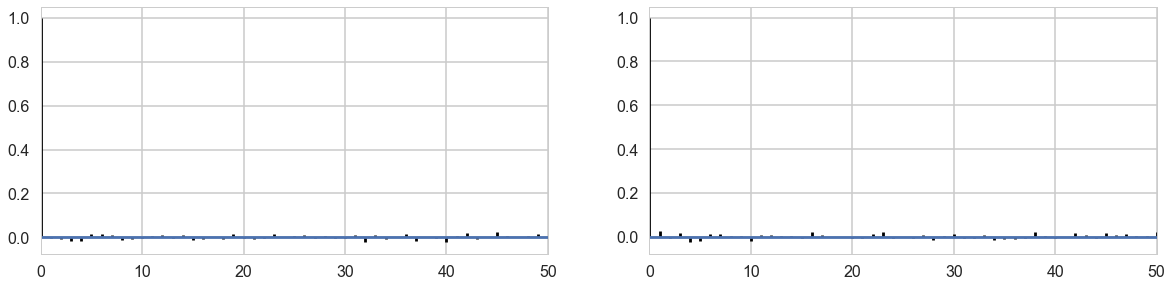

In [5]:
plt.figure(figsize=(20,10))
plt.subplot(221)
corrplot(samples[burnin::thin,0])
plt.subplot(222)
corrplot(samples[burnin::thin,1])

With the chosen burnin and thinning parameters, there appears to be no autocorrelation between samples. 

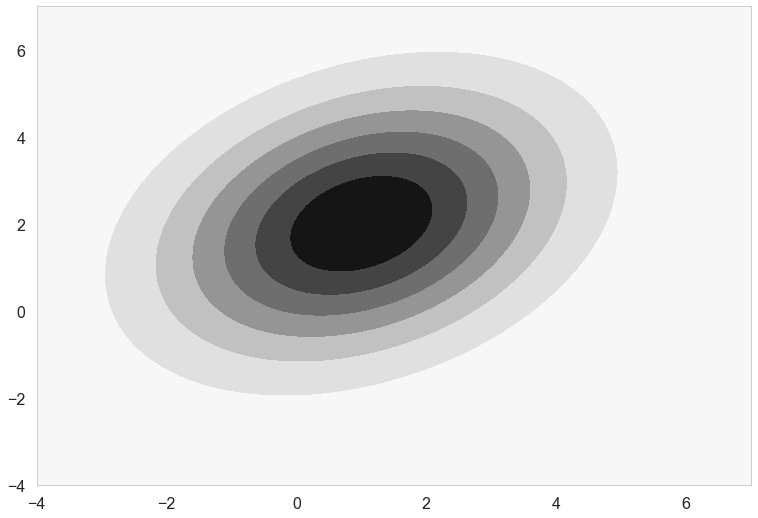

In [6]:
numgridpoints=400
x = np.linspace(-4,7,numgridpoints)
y = np.linspace(-4,7,numgridpoints)
xx,yy = np.meshgrid(x,y)
zz = np.zeros((numgridpoints,numgridpoints))
for i in np.arange(0,numgridpoints):
    for j in np.arange(0,numgridpoints):
        zz[i,j] = f_x(np.array([xx[i,j],yy[i,j]]))
plt.contourf(xx,yy,zz)      

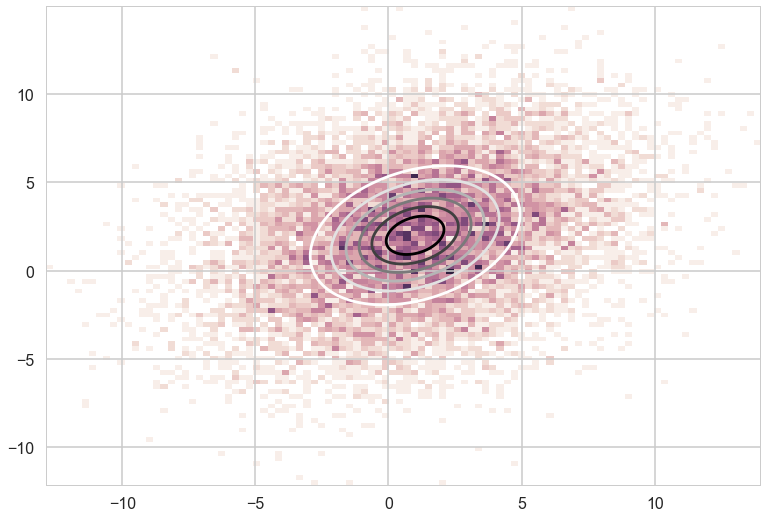

In [8]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.hist2d(samples[burnin::thin,0],samples[burnin::thin,1], normed=True, bins=100, cmap=cmap)
plt.contour(xx,yy,zz)  
plt.show()

## Problem 2: Bayesian Inference and All That
In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](lotus1.png) |  ![alt](toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](lotus2.png) |  ![alt](toysmith2.png)


In the following, we will ask you to compare these two products using the various rating statistics. Larger versions of the images are available in the data set accompanying this notebook.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


### Part A: Inference

- Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

- Write an expression for the posterior pdf, using a using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

- Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
- Sample 1,000 values of $\theta$ from the *posterior predictive distribution*.


In [10]:
# multinomial likelihood f(x|theta)
n_1 = 162
n_2 = 410
x_1 = np.array([0.06, 0.04, 0.06, 0.17, 0.67])*n_1
x_2 = np.array([0.14, 0.08, 0.07, 0.11, 0.60])*n_2

# dirichelt prior f(theta)
alphas = [5,1,1,1,5] # represent pseudo counts for each of the ratings 
prior = lambda n_samples: stats.dirichlet.rvs(alphas, n_samples)

# posterior pdf 
post_alpha_1 = x_1 + alphas
post_alpha_2 = x_2 + alphas

posterior_1 = lambda n_samples: stats.dirichlet.rvs(post_alpha_1, n_samples)
posterior_2 = lambda n_samples: stats.dirichlet.rvs(post_alpha_2, n_samples)

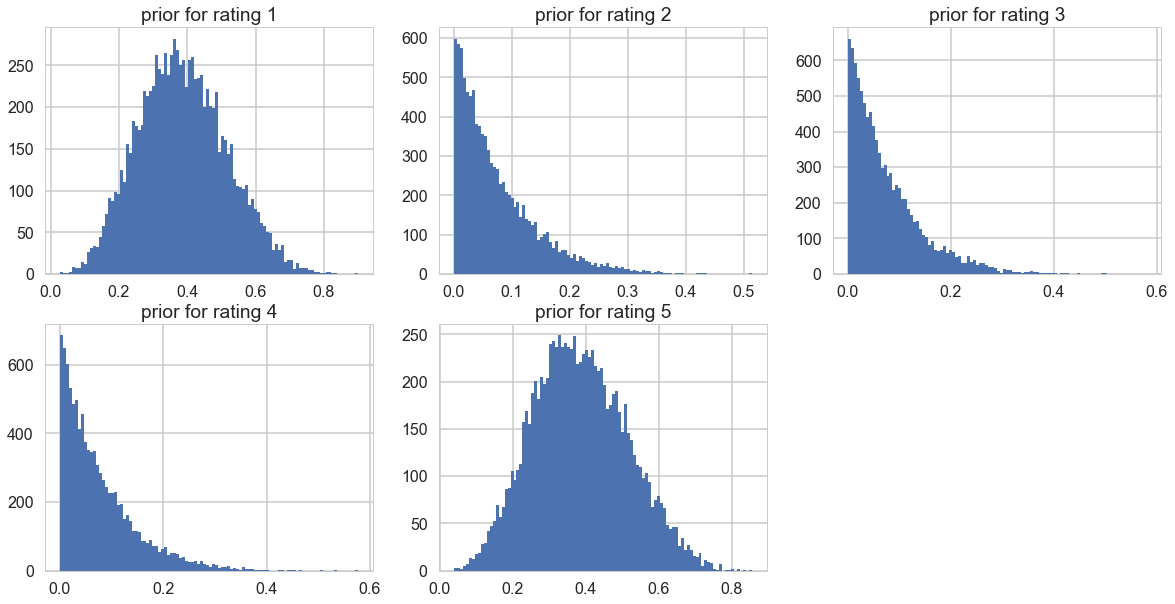

In [36]:
plt.figure(figsize=(20,10))
for i in range(1,6):
    plt.subplot("23"+str(i))
    plt.hist(ps[:,i-1], bins=100)
    plt.title('prior for rating '+str(i))

In [46]:
n_samples = 1000
thetas_1 = posterior_1(n_samples)
thetas_2 = posterior_2(n_samples)

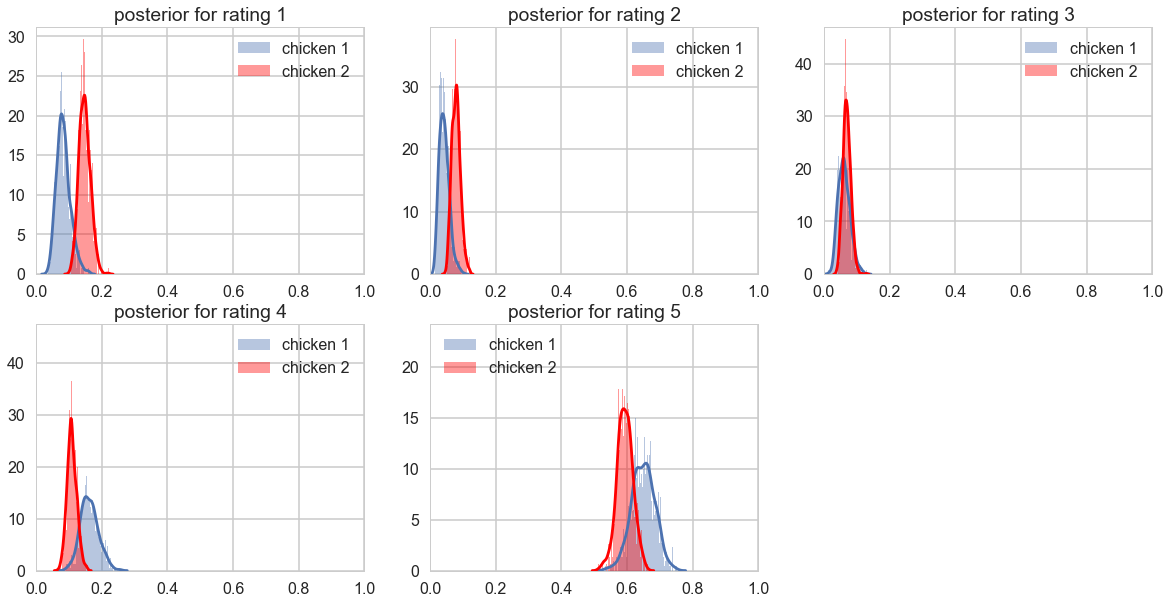

In [56]:
## sample from the posterior and put it back into the likelihood
plt.figure(figsize=(20,10))
for i in range(1,6):
    plt.subplot("23"+str(i))
    sns.distplot(thetas_1[:,i-1], bins=100, label='chicken 1')
    sns.distplot(thetas_2[:,i-1], bins=100, color='red', label='chicken 2')
    sns.plt.xlim([0,1])
    plt.title('posterior for rating '+str(i))
    plt.legend()

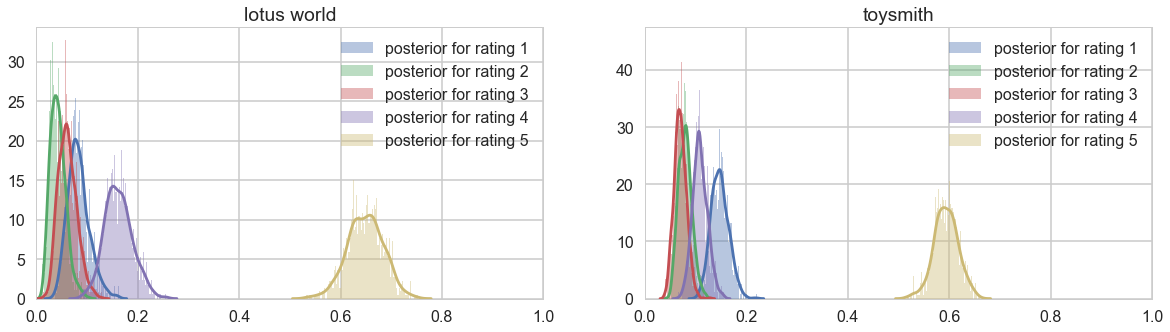

In [83]:
## sample from the posterior and put it back into the likelihood
plt.figure(figsize=(20,5))
plt.subplot(121)
for i in range(1,6):
    sns.distplot(thetas_1[:,i-1], bins=100, label='posterior for rating '+str(i))
    sns.plt.xlim([0,1])
    plt.title('lotus world')
    plt.legend()
plt.subplot(122)
for i in range(1,6):
    sns.distplot(thetas_2[:,i-1], bins=100, label='posterior for rating '+str(i))
    sns.plt.xlim([0,1])
    plt.title('toysmith')
    plt.legend()

In [59]:
## posterior predictive - sample from posterior and then sample from the likelihood 
posterior_pred_1 = np.zeros((n_samples, 5))
posterior_pred_2 = np.zeros((n_samples, 5))
for i in range(n_samples):
    pvals_1 = thetas_1[i, :]
    posterior_pred_1[i,:] = np.random.multinomial(1, pvals_1)
    pvals_2 = thetas_2[i, :]
    posterior_pred_2[i,:] = np.random.multinomial(1, pvals_2)

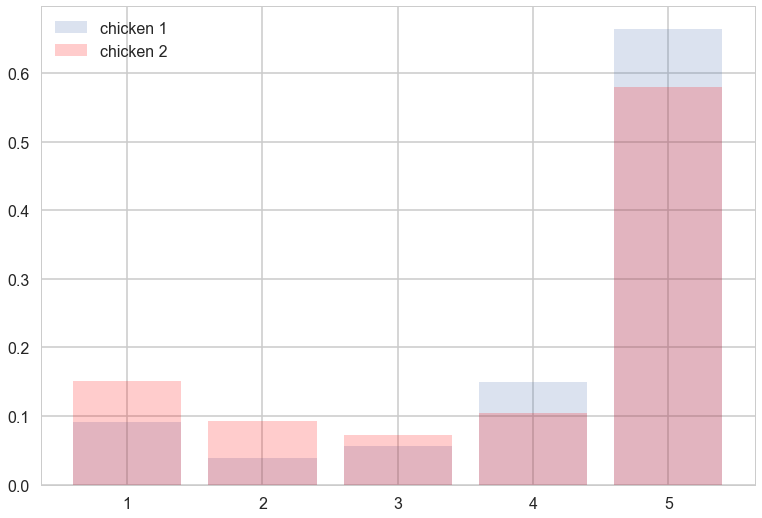

In [73]:
posterior_pred_1_counts = np.sum(posterior_pred_1, axis=0)
posterior_pred_2_counts = np.sum(posterior_pred_2, axis=0)
plt.bar([1,2,3,4,5], posterior_pred_1_counts/n_samples, alpha=0.2, label='chicken 1')
plt.bar([1,2,3,4,5], posterior_pred_2_counts/n_samples, color='red', alpha=0.2, label='chicken 2')
plt.legend()

### Part B: Ranking

- Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
 

Averages do not account for the number of ratings e.g. if product 1 has one rating of rating 1, and 5 of rating 5, and product 2 has 100 ratings of rating 1 and 500 of rating 5, both products will have the same average rating but with more observations for product 2, we can be more sure about the average rating being indicative of its quality as it has been verified by a larger number of people. 

- Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

- Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

- Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)

In [88]:
mean_rating_1 = np.sum(posterior_pred_1_counts*[1,2,3,4,5])/n_samples
mean_rating_2 = np.sum(posterior_pred_2_counts*[1,2,3,4,5])/n_samples

In [89]:
print('mean 1 ', mean_rating_1)
print('mean 2 ', mean_rating_2)

mean 1  4.257
mean 2  3.869


From the posterior distribution, rubber chicken 1 (lotus world) appears to be superior to rubber chicken 2 as the posterior probabilities for ratings 4 and 5 have greater probability and appear to have higher density.  

From the posterior predictive distribution, rubber chicken 1 (lotus world) appears to be superior to rubber chicken 2, as a larger number of the predicted ratings are 4 and 5 (~75% for chicken 1 compared to 68%). Rubber chicken 2 has a larger percentage of 1 and 2 star ratings (~32% for chicken 2 compared to ~18% for chicken 1). Considering the mean ratings, rubber chicken 1 also appears to be superior - it has a mean of 4.2 whereas rubber chicken 2 has a mean of 3.8. 